# Wind energy production forecast from Met.no weather forecast

In [1]:
%matplotlib notebook
import urllib.request
import numpy as np
import simplejson as json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import datetime
import dateutil.parser
import matplotlib.cbook
from mpl_toolkits.basemap import Basemap
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import requests
from netCDF4 import Dataset
from dh_py_access.lib.dataset import dataset as dataset
import dh_py_access.package_api as package_api
import dh_py_access.lib.datahub as datahub
np.warnings.filterwarnings('ignore')

With this notebook we illustrate how one might improve weather forecast for wind energy production, considering that turbine height is different from 10m wind height, that is usual in weather data, and that wind energy production does not depend only on wind speed, but also air density.

We look at weather data that is available for the Baltic Sea region, which is well covered by http://data.planetos.com/datasets/metno_harmonie_wind_det

In [2]:
API_key = open("APIKEY").read().strip()
dh=datahub.datahub_main(API_key)

We use a simple dh_py_access library for controlling REST requests.

In [3]:
fmi_hirlam_surface = dataset('fmi_hirlam_surface',dh)
metno_harmonie_metcoop = dataset('metno_harmonie_metcoop',dh)
metno_harmonie_wind = dataset('metno_harmonie_wind_det',dh)
gfs = dataset('noaa_gfs_pgrb2_global_forecast_recompute_0.25degree',dh)

dh_py_access provides some easy to use functions to list dataset metadata

In [4]:
## Does not look good in github 
##gfs.variable_names()

Initialize coordinates and reftime. Please not that more recent reftime, than computed below, may be available for particular dataset. We just use conservative example for demo

In [5]:
lon = 22
lat = 59+6./60
today = datetime.datetime.today()
reft = datetime.datetime(today.year,today.month,today.day,int(today.hour/6)*6) - datetime.timedelta(hours=12)
reft = reft.isoformat()
##reft = "2018-02-11T18:00:00"
arg_dict = {'lon':lon,'lat':lat,'reftime_start':reft,'reftime_end':reft,'count':250}
arg_dict_metno_wind_det = dict(arg_dict, **{'vars':'wind_u_z,wind_v_z,air_density_z'})
arg_dict_metno_harm_metcoop = dict(arg_dict, **{'vars':'u_wind_10m,v_wind_10m'})
arg_dict_hirlam = dict(arg_dict, **{'vars':'u-component_of_wind_height_above_ground,v-component_of_wind_height_above_ground'})
arg_dict_gfs = dict(arg_dict, **{'vars':'ugrd_m,vgrd_m','count':450})

Fetch data and convert to Pandas dataframe

In [6]:
dmw = metno_harmonie_wind.get_json_data_in_pandas(**arg_dict_metno_wind_det)
dmm = metno_harmonie_metcoop.get_json_data_in_pandas(**arg_dict_metno_harm_metcoop)
dhs = fmi_hirlam_surface.get_json_data_in_pandas(**arg_dict_hirlam)
dgfs = gfs.get_json_data_in_pandas(**arg_dict_gfs)

Filter out necessary data from the DataFrames

<IPython.core.display.Javascript object>


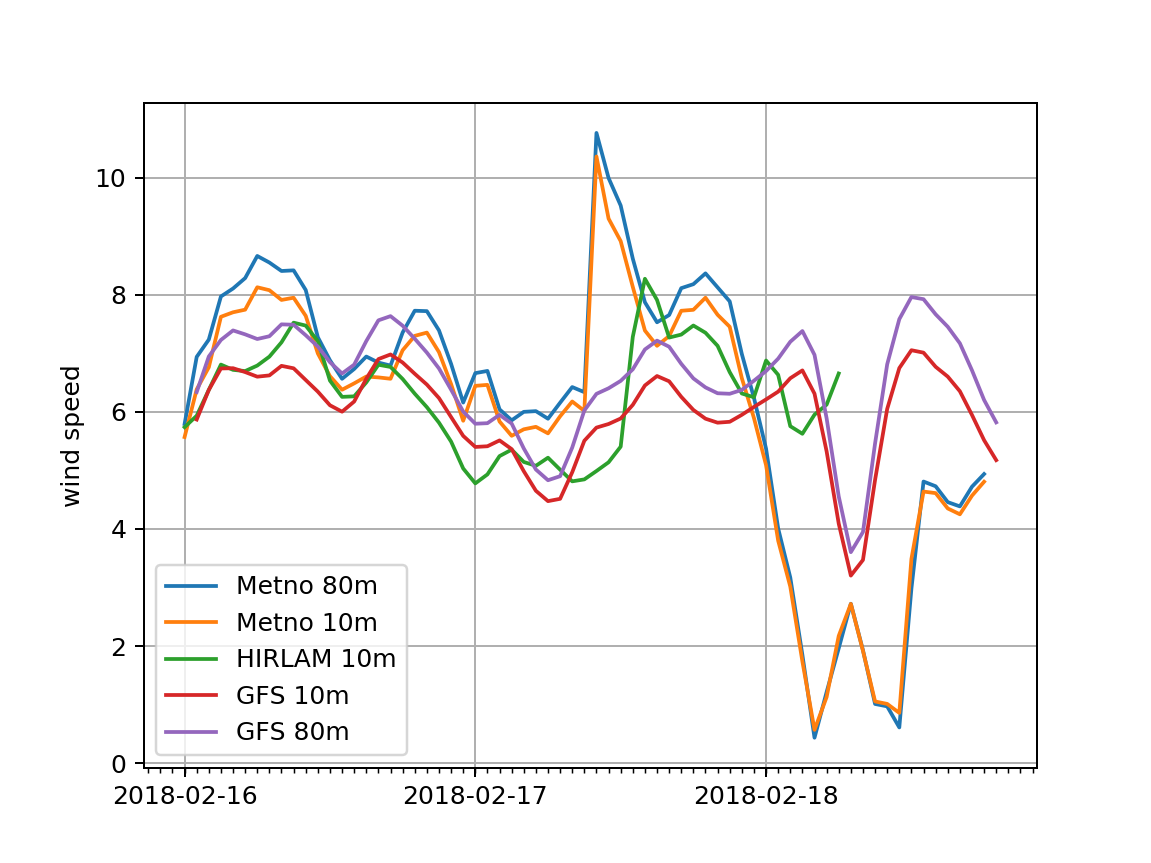

In [7]:
vel80_metno = np.array(np.sqrt(dmw[dmw['z']==80]['wind_u_z']**2 + dmw[dmw['z']==80]['wind_v_z']**2))
vel10_metno = np.array(np.sqrt(dmm['u_wind_10m']**2 + dmm['v_wind_10m']**2))
vel10_hirlam = np.array(np.sqrt(dhs['u-component_of_wind_height_above_ground']**2 + 
                          dhs['v-component_of_wind_height_above_ground']**2))
vel10_gfs = np.sqrt(dgfs[dgfs['z']==10]['ugrd_m']**2+dgfs[dgfs['z']==10]['vgrd_m']**2)
vel80_gfs = np.sqrt(dgfs[dgfs['z']==80]['ugrd_m']**2+dgfs[dgfs['z']==80]['vgrd_m']**2)
t_metno = [dateutil.parser.parse(i) for i in dmw[dmw['z']==80]['time']]
t_metno_10 = [dateutil.parser.parse(i) for i in dmm['time']]
t_hirlam = [dateutil.parser.parse(i) for i in dhs['time']]
t_gfs_10 = [dateutil.parser.parse(i) for i in dgfs[dgfs['z']==10]['time']]
t_gfs_80 = [dateutil.parser.parse(i) for i in dgfs[dgfs['z']==80]['time']]

fig, ax = plt.subplots()
days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%Y-%m-%d')
hours = mdates.HourLocator()
ax.set_ylabel("wind speed")
ax.plot(t_metno, vel80_metno, label='Metno 80m')
ax.plot(t_metno_10, vel10_metno, label='Metno 10m')
ax.plot(t_hirlam, vel10_hirlam, label='HIRLAM 10m')
gfs_lim=67
ax.plot(t_gfs_10[:gfs_lim], vel10_gfs[:gfs_lim], label='GFS 10m')
ax.plot(t_gfs_80[:gfs_lim], vel80_gfs[:gfs_lim], label='GFS 80m')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daysFmt)
ax.xaxis.set_minor_locator(hours)
#fig.autofmt_xdate()
plt.legend()
plt.grid()
plt.savefig("model_comp")

We easily see that differences between models can be larger than difference of 10m to 80m winds in the same model.

It should also be apparent (depends on date) that the difference between 10m and 80m wind is not constant on Met.no harmonie case, i.e. it is not really possible to get accurate 80m wind by knowing lower level wind data only.

What role does air density play in energy production?
From the theory we know that wind energy production is roughly 

$$1/2 A \rho \mathbf{v}^3$$

where $A$ is area, $\rho$ is air density and $\mathbf{v}$ is wind speed. We are not concerned about $A$, which is a turbine parameter, but we can analyse the linear relation of density and cube relation of wind speed itself.

First, let's see how the density varies over time

<IPython.core.display.Javascript object>


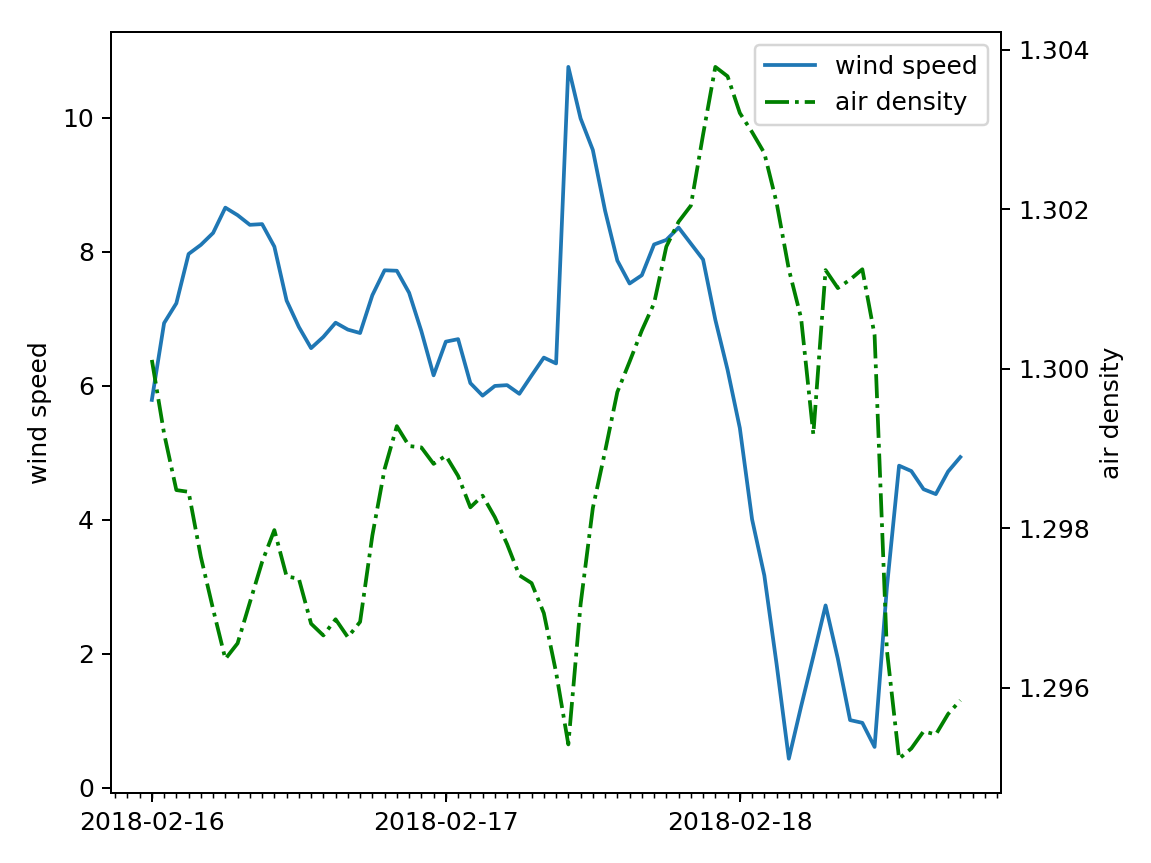

In [8]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%Y-%m-%d')
hours = mdates.HourLocator()
ax.plot(t_metno,vel80_metno,label="wind speed")

aird80 = dmw[dmw['z']==80]['air_density_z']
ax2.plot(t_metno, aird80, '-.', c='g', label='air density')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daysFmt)
ax.xaxis.set_minor_locator(hours)
ax.set_ylabel("wind speed")
ax2.set_ylabel("air density")
fig.tight_layout()
#fig.autofmt_xdate()
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
## plt.legend()
plt.savefig("density_80m")

The difference is usually not much larger than a few %, for single point.

In order to make a more thorough analysis for the influence of air density, we download the data for the full domain and all available timesteps.

In [9]:
metno_pkg = package_api.package_api(dh,'metno_harmonie_wind_det','air_density_z,wind_u_z,wind_v_z',-20,60,10,80,'full_domain_harmonie',z=0) 
metno_pkg.make_package()
metno_pkg.download_package()
metno_data = Dataset(metno_pkg.get_local_file_name())

Package exists
File already downloaded


In [10]:
def get_power_production(ws,aird):
    return aird * ws**3

def get_wspeed(u,v):
    return np.sqrt(u**2 + v**2)

## Importance of the air density in energy production

* main  -- compute power production with full density information at each timestep
* test -- compute the power production using the average air density of particular point, to minimize systematic differences related to surface height.
* The plots are given as relative differences, integrated over the forecast period, $$\frac{test - main}{main}$$ 

In [17]:
ws = get_wspeed(metno_data.variables['wind_u_z'][:],metno_data.variables['wind_v_z'][:])
power_main = np.trapz(get_power_production(ws, metno_data.variables['air_density_z'][:]),axis=0)
power_test = np.trapz(get_power_production(ws, np.nanmean(metno_data.variables['air_density_z'][:],axis=0)),axis=0)

<IPython.core.display.Javascript object>


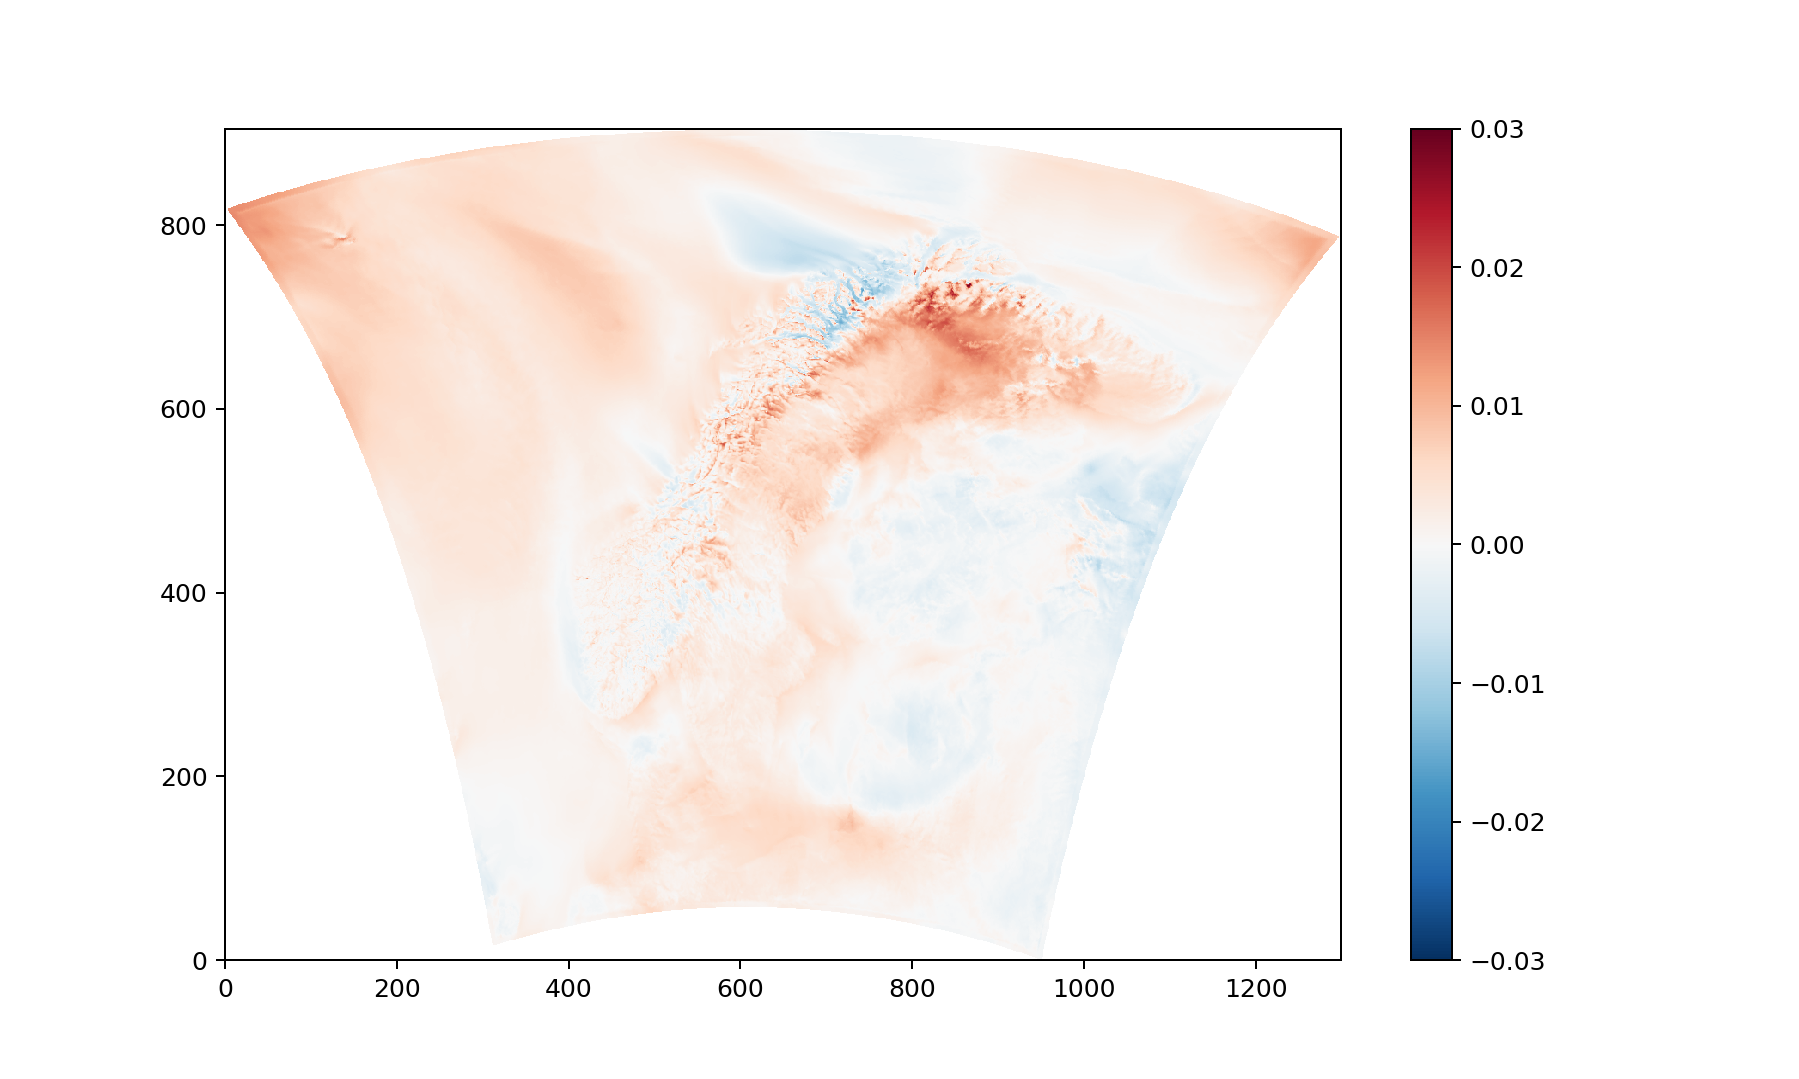

In [33]:
fig =plt.figure(figsize=(10,6))
plt.pcolormesh(((power_test - power_main) / power_main)[0,:,:],vmin=-0.03, vmax=0.03,cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.savefig()

From the test we see that the difference in total production prediction within a single forecast does not exceed a few percent. But wind energy forecast is not about total values, but more like 1 hr or 15 min range, so it is important to look at the differences in as high temporal resolution, as available. 



In [114]:
pdiff = get_power_production(ws, metno_data.variables['air_density_z'][:]) - get_power_production(ws, np.nanmean(metno_data.variables['air_density_z'][:]))
diffrel = pdiff/get_power_production(ws, metno_data.variables['air_density_z'][:])
diffrel=np.ma.masked_where(np.isnan(diffrel),diffrel)

<IPython.core.display.Javascript object>


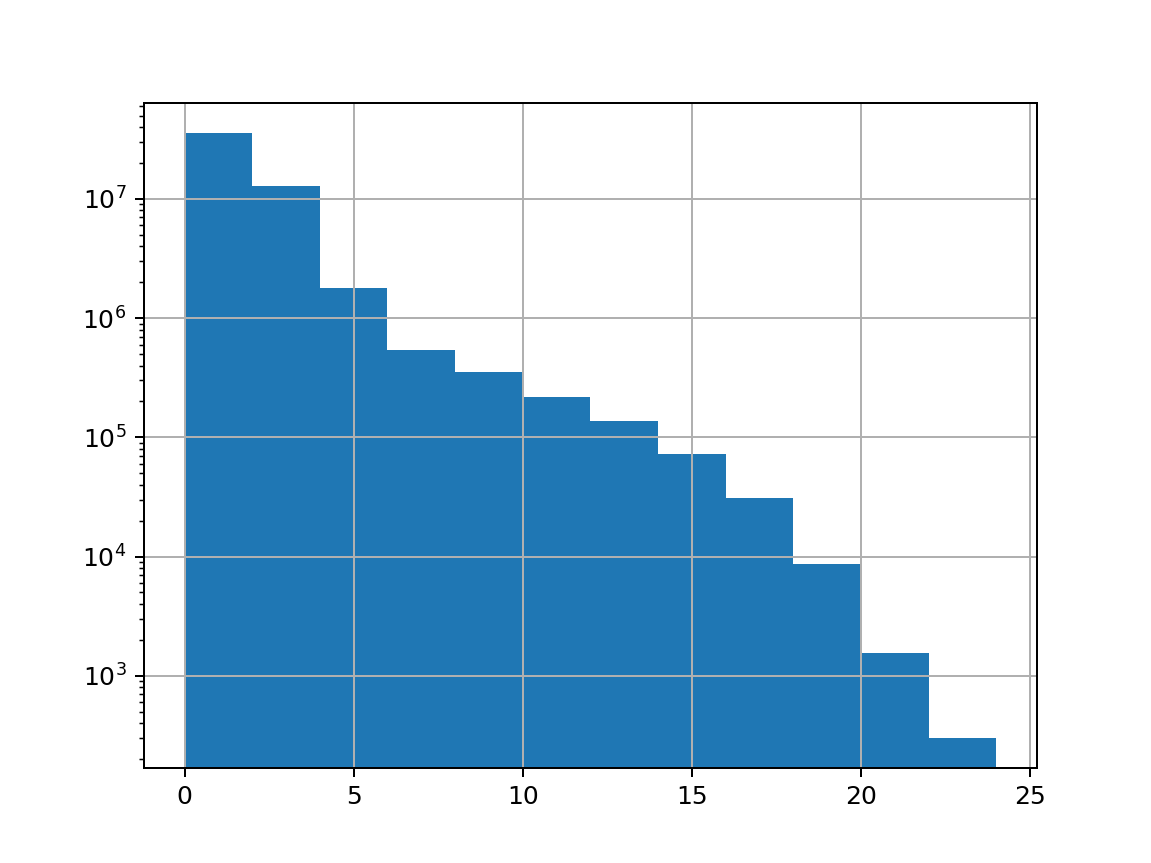

In [115]:
fig, ax=plt.subplots()
plt.hist(np.abs(diffrel.compressed())*100,bins=np.arange(0,26,2))
plt.yscale('log')
plt.grid()
plt.savefig("hourdiff")
plt.show()

In [116]:
print(pdiff.shape)
print(diffrel.shape)

(67, 1, 905, 1299)
(67, 1, 905, 1299)


In [117]:
np.histogram(np.abs(diffrel.compressed()),bins=np.arange(0,0.35,0.05))

(array([49933294,  1384649,   395959,    69596,     1866,        0]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]))

In [118]:
np.histogram(np.abs(diffrel.compressed()),bins=np.arange(0,0.35,0.05))[0]/np.size(diffrel.compressed()) * 100

array([9.64235648e+01, 2.67382305e+00, 7.64615655e-01, 1.34393185e-01,
       3.60333472e-03, 0.00000000e+00])